In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to generate a random qubit state uniformly distributed on the Bloch sphere.
def random_qubit_state():
    theta = np.random.uniform(0, np.pi)         # Polar angle
    phi = np.random.uniform(0, 2 * np.pi)       # Azimuthal angle
    gamma = np.random.uniform(0, 2 * np.pi)     # Global phase angle
    a = np.cos(theta / 2) * np.exp(1j * gamma)
    b = np.sin(theta / 2) * np.exp(1j * (phi + gamma))
    return a, b

# Extract the bit at the specified index
def get_bit(value, bit_index):
    return (value >> bit_index) & 1

# Set the bit at the specified index to 0 or 1
def set_bit(value, bit_index, bit_value):
    if bit_value:
        return value | (1 << bit_index)
    else:
        return value & ~(1 << bit_index)
        
# Function to initialize the state of the register assuming independent qubits
def initialize_density_independent(N):
    density = np.zeros(2**N, dtype=complex)
    
    # Generate N independent qubit states
    qubit_states = [random_qubit_state() for _ in range(N)]
    
    # Compute the density for each of the 2^N states
    for i in range(2**N):
        amplitude = 1.0
        for qubit in range(N):
            bit_value = get_bit(i, qubit)
            a, b = qubit_states[qubit]
            amplitude *= a if bit_value == 0 else b
        density[i] = amplitude

    density /= np.linalg.norm(density)
    
    return density

# Function to apply a quantum gate to two specific qubits in an N-qubit register
def apply_two_qubit_gate(density, i_q1, i_q2, N, gate_matrix):
    num_states = 2 ** N
    new_density = np.zeros(num_states, dtype=complex)
    
    for i in range(num_states):
        # Get the current bit values for the two qubits
        b1 = get_bit(i, i_q1)
        b2 = get_bit(i, i_q2)
        sub_index = (b2 << 1) | b1
        
        for offset in range(4):
            # Calculate new bit values after applying the gate
            b1_new = offset & 1
            b2_new = (offset >> 1) & 1
            
            # Set the new index based on the new bit values
            i_new = set_bit(i, i_q1, b1_new)
            i_new = set_bit(i_new, i_q2, b2_new)
            
            # Update the new density
            new_density[i_new] += gate_matrix[offset][sub_index] * density[i]
    
    return new_density

# Function to plot the density evolution over multiple steps
def plot_density_evolution(densities):
    num_steps = len(densities)
    num_states = len(densities[0])
    
    # Find the maximum magnitude across all steps for normalization
    max_magnitude = max(np.abs(density).max() for density in densities)
    
    # Create an empty 2D array to store color data for all steps
    colors = np.zeros((num_steps, num_states, 3))
    
    for step, density in enumerate(densities):
        for i in range(num_states):
            magnitude = np.abs(density[i])
            phase = np.angle(density[i])
            
            # Normalize the magnitude using the global maximum
            brightness = magnitude / max_magnitude
            # Normalize the phase to a hue value (0 to 1)
            hue = (phase + np.pi) / (2 * np.pi)
            
            # Apply the HSV color map and adjust brightness
            colors[step, i, :] = np.array(plt.cm.hsv(hue)[:3]) * brightness
    
    # Display the accumulated color array as an image
    plt.figure(figsize=(plt.gcf().get_size_inches()[0]*2, num_steps/8))
    plt.imshow(colors, aspect='auto', interpolation='nearest', origin='lower')
    plt.title('Density Evolution Over Time')
    plt.axis('off')
    plt.show()

# Function to simulate quantum interactions and track the density evolution
def simulate_qubits_with_evolution(N, steps):
    density = initialize_density_independent(N)
    densities = [density.copy()]  # Store the initial density
    
    sqrt_swap_matrix = np.array([
        [1, 0, 0, 0],
        [0, (1+1j)/2, (1-1j)/2, 0],
        [0, (1-1j)/2, (1+1j)/2, 0],
        [0, 0, 0, 1]
    ])
    
    # Print the initial norm (DEBUG)
    # print(f"Step 0: Norm = {np.linalg.norm(density)}")
    
    for step in range(1, steps + 1):
        i_q1, i_q2 = random.sample(range(N), 2)
        density = apply_two_qubit_gate(density, i_q1, i_q2, N, sqrt_swap_matrix)
        densities.append(density.copy())  # Store the density after each step
        
        # Print the norm after each step (DEBUG)
        # print(f"Step {step}: Norm = {np.linalg.norm(density)}")
    
    plot_density_evolution(densities)

<Figure size 640x480 with 0 Axes>

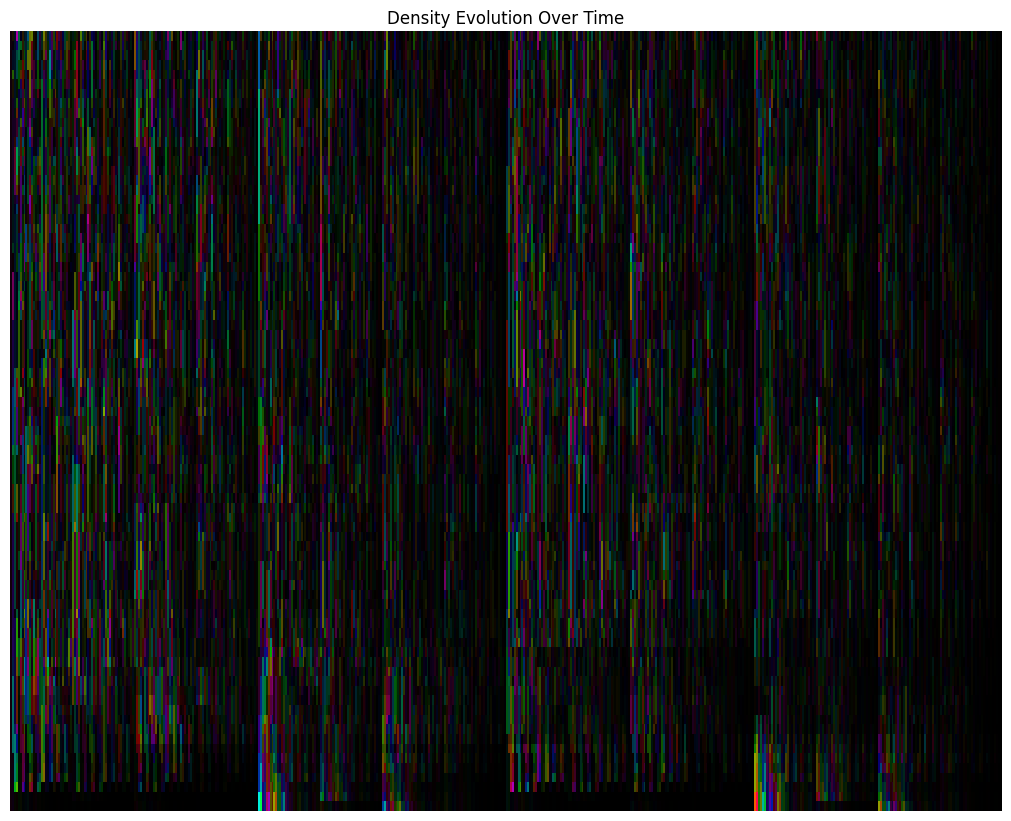

In [11]:
N = 9
steps = 80
simulate_qubits_with_evolution(N, steps)